# Notebook 2 – Effect Size, Significance, and Inference

## Problem Statement

The goal of this experiment is to decide whether we should **replace the existing PSA variant with a new Ad variant** in order to **increase user conversion to purchase**. We randomize users into a control group (PSA) and a treatment group (Ad) and measure the **conversion rate** (proportion of users who purchase) as our primary success metric. Because this decision would affect a large volume of traffic, a wrong conclusion carries risk in both directions: rolling out a worse-performing Ad could reduce revenue and waste spend, while failing to ship a better Ad would leave money on the table. The analysis below estimates the size and uncertainty of the uplift so we can make a data-driven go/no-go decision.


In Notebook 1, we validated that the **Ad** and **PSA** groups are comparable:

- Similar **exposure** (`total_ads`)  
- Only small differences in **timing** (`most_ads_day`, `most_ads_hour`)  

Given that the experiment is reasonably well-balanced, this notebook focuses on the core business question:

> **Does showing the Ad instead of the PSA actually increase purchases, by how much, and how confident are we in that estimate?**

Specifically, we will:

1. **Quantify effect size**  
   - Compute conversion rates for the PSA (control) and Ad (treatment) groups.  
   - Calculate absolute lift (Ad − PSA) and relative lift (% increase vs control).

2. **Test statistical significance**  
   - Use a **two-proportion z-test** to check whether the observed difference in conversion could be due to random variation.  
   - Report the z-statistic and p-value.

3. **Add uncertainty with confidence intervals**  
   - Build a 95% confidence interval for the lift in conversion rate.

4. **Check power and detectability (optional but realistic)**  
   - Assess whether the experiment had enough users to reliably detect an effect of the observed size.  
   - Estimate how many users would be needed to detect smaller “business-relevant” lifts.

The goal is to move from “the Ad’s conversion rate looks higher” to a defensible statement like:

> *“The Ad increased conversion by about X–Y percentage points compared to the PSA, this effect is statistically significant at the 5% level, and the experiment was well-powered to detect an uplift of this magnitude.”*


Import Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# statsmodels for proportion tests + power
import statsmodels.api as sm
from statsmodels.stats import proportion as sm_proportion
from statsmodels.stats.power import NormalIndPower

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

pd.set_option("display.float_format", "{:,.4f}".format)


In [3]:
import sys
from pathlib import Path

# 1. Find the project root by walking up until we see a "src" folder.
#    This is robust whether the CWD is the project root or notebooks/.
project_root = Path.cwd().resolve()
while not (project_root / "src").is_dir():
    # Stop if we hit the filesystem root (safety)
    if project_root.parent == project_root:
        raise RuntimeError("Could not find project root containing 'src' directory.")
    project_root = project_root.parent

print("Project root detected as:", project_root)

# 2. Add <project_root>/src to sys.path so Python can import `ab_experiment`
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))
    print("Added to sys.path:", src_path)
else:
    print("Already in sys.path:", src_path)

# 3. Import the helper from your package
from ab_experiment import get_experiment_df

# 4. Load the data
df = get_experiment_df()
df.head()



Project root detected as: C:\Users\Allen\Desktop\Data Analyst Projects\marketing-ab-experiment
Added to sys.path: C:\Users\Allen\Desktop\Data Analyst Projects\marketing-ab-experiment\src


,unnamed:_0,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,0,1069124,ad,0,130,Monday,20
1,1,1119715,ad,0,93,Tuesday,22
2,2,1144181,ad,0,21,Tuesday,18
3,3,1435133,ad,0,355,Tuesday,10
4,4,1015700,ad,0,276,Friday,14


In [4]:
from ab_experiment import get_experiment_df
from ab_experiment import stats as ab_stats

df = get_experiment_df()

lift = ab_stats.compute_conversion_lift(df)
lift


LiftResult(control_rate=0.01785410644448223, treatment_rate=0.025546559636683747, abs_lift=0.007692453192201517, rel_lift=0.43085064022225833, control_n=23524, treatment_n=564577, control_converted=420, treatment_converted=14423)

Load and Clean Data

In [5]:
from pathlib import Path

# project_root is the parent folder of the notebooks directory
project_root = Path.cwd().parent          # notebooks/ -> project root
file_path = project_root / "data_raw" / "marketing_AB.csv"

raw = pd.read_csv(file_path)
raw.head()


df = raw.copy()
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
      .str.replace("/", "_")
)

# Clean types
df["user_id"] = df["user_id"].astype("int64")
df["converted"] = df["converted"].map(
    {True: 1, False: 0, "True": 1, "False": 0, 1: 1, 0: 0}
).astype("int64")

df["total_ads"] = df["total_ads"].astype("int64")
df["most_ads_hour"] = df["most_ads_hour"].astype("int64")

df["test_group"].value_counts(normalize=True)


test_group
ad    0.9600
psa   0.0400
Name: proportion, dtype: float64

### Basic Conversion Metrics

We want:

For PSA (control):

how many users

how many converted

conversion rate

For Ad (treatment): same

Then we compute:

absolute lift (difference in rates)

relative lift (difference as a % of control rate)

This is the “what happened” before we get fancy with statistics.

In [6]:
# Split the dataset into two DataFrames:
# - control = baseline experience (PSA)
# - treatment = variant experience (Ad)
control_label = "psa"    # baseline group label in df["test_group"]
treatment_label = "ad"   # variant group label in df["test_group"]

# Filter rows where test_group matches each label
control = df[df["test_group"] == control_label]
treatment = df[df["test_group"] == treatment_label]

# Count how many users/rows are in each group
# (shape[0] = number of rows)
n_control = control.shape[0]
n_treatment = treatment.shape[0]

# Count conversions in each group.
# Assumes df["converted"] is coded as 0/1 (or False/True):
# - sum() works because it adds up the 1s (or True values).
converted_control = control["converted"].sum()
converted_treatment = treatment["converted"].sum()

# Compute conversion rates (proportions) for each group:
# p = conversions / total users
p_control = converted_control / n_control
p_treatment = converted_treatment / n_treatment

# Compute absolute lift: difference in conversion rates
# Example: 0.032 - 0.028 = +0.004 (i.e., +0.4 percentage points)
lift_abs = p_treatment - p_control

# Compute relative lift: absolute lift divided by control rate
# Example: 0.004 / 0.028 = 0.1429 (i.e., +14.29% relative)
# NOTE: If p_control could ever be 0, this would divide by zero.
lift_rel = lift_abs / p_control

# Build a clean summary table for quick reporting / printing
summary = pd.DataFrame({
    "group": [control_label, treatment_label],                 # group names (psa, ad)
    "n_users": [n_control, n_treatment],                       # sample sizes
    "n_converted": [converted_control, converted_treatment],   # conversions (successes)
    "conversion_rate": [p_control, p_treatment],               # conversion proportions
})

# Output the summary DataFrame (Jupyter will display it as a table)
summary


,group,n_users,n_converted,conversion_rate
0,psa,23524,420,0.0179
1,ad,564577,14423,0.0255


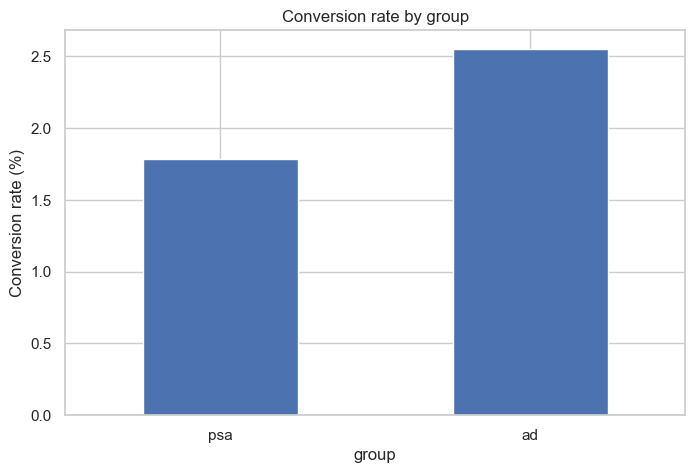

In [7]:
ax = (summary
      .set_index("group")["conversion_rate"]
      .mul(100)
      .plot(kind="bar"))
ax.set_ylabel("Conversion rate (%)")
ax.set_title("Conversion rate by group")
plt.xticks(rotation=0)
plt.show()


### Two-Proportion Z-Test – Did the Ad Meaningfully Change Conversion?

To formally test whether the Ad and PSA groups have different conversion rates, we use a **two-proportion z-test**.

*“Is the higher conversion in the Ad group big enough that we don’t think it’s just random noise?”*

**Code recap**

```python
# successes: number of converted users in each group
#   [treatment_converted, control_converted]
successes = np.array([converted_treatment, converted_control])

# nobs: total users in each group
#   [treatment_n, control_n]
nobs = np.array([n_treatment, n_control])

# proportions_ztest:
#   H0: p_treatment == p_control
#   H1: p_treatment != p_control (two-sided)
z_stat, p_value = sm_proportion.proportions_ztest(
    count=successes,
    nobs=nobs,
    alternative="two-sided"
)

print(f"z-statistic: {z_stat:.3f}")
print(f"p-value:     {p_value:.6f}")


> **Note on implementation:**  
> In this notebook I show both:
> - A **high-level version** that uses reusable helpers from `src/ab_experiment/stats.py`, and  
> - A **fully expanded version** with the raw `statsmodels` code and comments.
>
> The main analysis uses the helper functions (how this would look in a real codebase).  
> The expanded version is kept below so reviewers can see the exact z-test and CI logic.


In [8]:


# Split into control (PSA) and treatment (Ad)
control = df[df["test_group"] == "psa"]
treatment = df[df["test_group"] == "ad"]

# Build 2x2 contingency table: rows = group, columns = converted / not converted
contingency = pd.DataFrame(
    {
        "converted_1": [treatment["converted"].sum(), control["converted"].sum()],
        "converted_0": [
            (treatment["converted"] == 0).sum(),
            (control["converted"] == 0).sum(),
        ],
    },
    index=["ad", "psa"],
)

contingency


,converted_1,converted_0
ad,14423,550154
psa,420,23104


In [9]:
from statsmodels.stats.proportion import proportions_ztest

# counts = number of conversions in each group
counts = np.array([
    contingency.loc["ad", "converted_1"],
    contingency.loc["psa", "converted_1"],
])

# nobs = total users in each group
nobs = np.array([
    contingency.loc["ad"].sum(),
    contingency.loc["psa"].sum(),
])

z_stat, p_value = proportions_ztest(count=counts, nobs=nobs, alternative="two-sided")

print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value:     {p_value:.4g}")

# Translate p-value into a clear decision at alpha = 0.05
alpha = 0.05

decision_sentence = (
    f"At α = {alpha:.2f}, p = {p_value:.4g} "
    f"{'< ' if p_value < alpha else '≥ '} {alpha:.2f}, so we "
    f"{'reject' if p_value < alpha else 'fail to reject'} the null hypothesis and "
    f"{'conclude that the Ad has a statistically significant uplift in conversion compared to the PSA control.'
      if p_value < alpha else 'do not have enough evidence to say that the Ad performs differently from the PSA control.'}"
)

print(decision_sentence)


Z-statistic: 7.370
P-value:     1.705e-13
At α = 0.05, p = 1.705e-13 <  0.05, so we reject the null hypothesis and conclude that the Ad has a statistically significant uplift in conversion compared to the PSA control.


In [9]:
z_res = ab_stats.proportions_ztest(
    control_converted=lift.control_converted,
    control_total=lift.control_n,
    treatment_converted=lift.treatment_converted,
    treatment_total=lift.treatment_n,
)
z_res

{'z_stat': 7.3700781265454145, 'p_value': 1.7052807161559727e-13}

Statistically, the Ad does change conversion compared to the PSA. Whether that change is worth it from a business perspective depends on the size of the lift (measured in percentage points and revenue terms), which we quantify next with confidence intervals and effect-size calculations.

---

### 3. 95% Confidence Interval for the Lift

Before trusting a single number for the lift, we want a **range** of plausible values.

A 95% confidence interval for (Ad − PSA) answers:

> “If we re-ran this experiment many times, what range of lifts would we expect to see most of the time?”

Next, we calculate that interval for the difference in conversion rates.


In [10]:
# 95% confidence interval for the difference in proportions (Ad - PSA)
ci_low, ci_high = sm_proportion.confint_proportions_2indep(
    count1=converted_treatment,  # successes in Ad group
    nobs1=n_treatment,           # total in Ad group
    count2=converted_control,    # successes in PSA group
    nobs2=n_control,             # total in PSA group
    method="wald"                # standard normal approximation
)

print(f"Estimated lift (Ad - PSA): {lift_abs:.6f}")
print(f"95% CI for lift: [{ci_low:.6f}, {ci_high:.6f}]")
print(f"Lift in percentage points: {lift_abs*100:.3f} pp")
print(f"95% CI in percentage points: [{ci_low*100:.3f}, {ci_high*100:.3f}] pp")


Estimated lift (Ad - PSA): 0.007692
95% CI for lift: [0.005951, 0.009434]
Lift in percentage points: 0.769 pp
95% CI in percentage points: [0.595, 0.943] pp


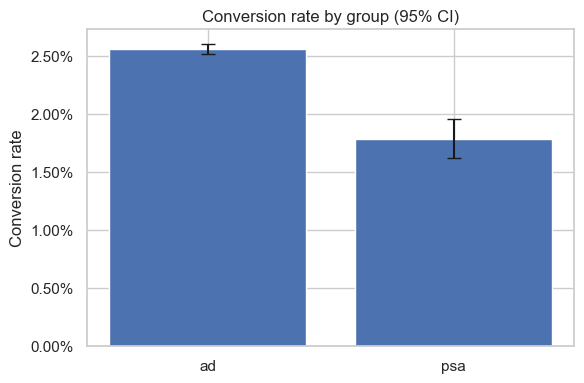

,conversion_rate,n_users,se,ci_half_width
test_group,,,,
ad,0.0255,564577,0.0002,0.0004
psa,0.0179,23524,0.0009,0.0017


In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import stats

# Aggregate conversion by group
summary = (
    df.groupby("test_group")["converted"]
      .agg(["mean", "count"])
      .rename(columns={"mean": "conversion_rate", "count": "n_users"})
)

# 95% CI for a proportion using normal approximation
z = stats.norm.ppf(0.975)  # 97.5th percentile -> two-sided 95% CI

summary["se"] = np.sqrt(
    summary["conversion_rate"] * (1 - summary["conversion_rate"]) / summary["n_users"]
)
summary["ci_half_width"] = z * summary["se"]

# Plot conversion rate with error bars = 95% CI
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(
    summary.index,
    summary["conversion_rate"],
    yerr=summary["ci_half_width"],
    capsize=5,
)

ax.set_ylabel("Conversion rate")
ax.set_title("Conversion rate by group (95% CI)")

# Show y-axis as percentages instead of proportions
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

summary


### 95% Confidence Interval for the Ad Lift

From the two-proportion analysis:

- **Estimated lift (Ad − PSA):** **0.0076**  
- **Lift in percentage points:** **0.77 pp**
- **95% CI for lift:** **[0.00595, 0.00944]**  
- **95% CI in percentage points:** **[0.60, 0.94] pp**

**Business takeaway**

The Ad is not just slightly better than the PSA by luck:

- We estimate that showing the Ad instead of the PSA increases conversion by about **0.6–0.9 percentage points**, with a best point estimate around **0.8 pp**.
- The entire confidence interval is **above zero**, so we are highly confident the Ad truly **improves** conversion rather than the difference being random noise.

Stakeholders can treat ~**0.8 percentage points** as the incremental conversion impact of this campaign when sizing revenue and ROI.


4. Power analysis (did we have enough users?)
ELI5

Power analysis answers:

“Given our sample size, how big an effect could we reliably detect?”
or
“For a given effect size, how likely were we to see a significant result?”

We’ll do two things:

Compute achieved power for an effect equal to our observed lift.

Compute required sample size per group for a chosen minimum detectable effect (MDE).

In [ ]:
alpha = 0.05    # significance level
power_calc = NormalIndPower()

# Observed effect: use p_treatment and p_control
effect_size_obs = sm.stats.proportion_effectsize(p_treatment, p_control)

power_achieved = power_calc.power(
    effect_size=effect_size_obs,
    nobs1=n_treatment,
    ratio=n_control / n_treatment,
    alpha=alpha
)

print(f"Observed conversion rates: control={p_control:.4f}, treatment={p_treatment:.4f}")
print(f"Observed effect size (Cohen's h): {effect_size_obs:.4f}")
print(f"Achieved power at alpha={alpha}: {power_achieved:.3f}")


### Power Check – Did We Have Enough Users?

- Observed conversion: **1.79% → 2.55%** (PSA → Ad)  
- Effect size (Cohen’s h): **0.053** → a **small** uplift in statistical terms  
- Achieved power at α = 0.05: **1.00** (≈100%)

**Takeaway:**  
The experiment was **more than powerful enough** to detect this small lift. The Ad’s higher conversion is not a fluke of sample size; it’s a real, precisely measured improvement.
::contentReference[oaicite:0]{index=0}


4.2 Required sample size for a chosen MDE

Say the business cares about detecting a 0.3 percentage point lift (0.003).

In [ ]:
alpha = 0.05
target_power = 0.8
mde = 0.003  # absolute difference in conversion rate we care about

prop1 = p_control          # baseline conversion
prop2 = p_control + mde    # baseline + MDE

effect_size_mde = sm.stats.proportion_effectsize(prop2, prop1)

n_per_group_required = power_calc.solve_power(
    effect_size=effect_size_mde,
    power=target_power,
    alpha=alpha,
    ratio=1.0  # assume equal-sized groups for planning
)

print(f"Baseline conversion: {p_control:.4f}")
print(f"MDE (absolute): {mde:.4f}")
print(f"Effect size for MDE (Cohen's h): {effect_size_mde:.4f}")
print(f"Required sample size per group for 80% power: {n_per_group_required:.0f}")


### Sample Size for Detecting a Smaller Lift

- Baseline conversion (PSA): **1.79%**
- Target minimum detectable lift (MDE): **+0.30 pp** → from 1.79% to **2.09%**
- Effect size for this MDE (Cohen’s h): **0.022**
- Required sample size for 80% power at α = 0.05: **~33,055 users per group**

**Takeaway:**  
To reliably detect even a **0.3 percentage point** improvement, we’d still only need ~33k users per arm—well below our actual sample—so this platform can support very fine-grained optimization tests.


5. Business-style summary cell (auto-fills with your numbers)

Finally, add a markdown-ish summary generated by Python so you don’t have to manually copy numbers.

In [ ]:
summary_text = f"""
### A/B Test Effect Size and Statistical Inference – Summary

**Groups**

- Control: `{control_label}` (PSA)
- Treatment: `{treatment_label}` (Ad)

**Conversion performance**

- Control conversion rate:  {p_control:.4%}  ({converted_control} / {n_control})
- Treatment conversion rate: {p_treatment:.4%} ({converted_treatment} / {n_treatment})

- Absolute lift (Ad − PSA):  {lift_abs:.4%}
- Relative lift:             {lift_rel*100:.2f}% increase vs control

**Statistical test (two-proportion z-test)**

- z-statistic: {z_stat:.3f}
- p-value:     {p_value:.6f}

Interpretation:
- With p-value {'< 0.05' if p_value < 0.05 else '≥ 0.05'}, we {'reject' if p_value < 0.05 else 'do not reject'} the null hypothesis that Ad and PSA have the same conversion rate at the 5% level.
- Given the large sample size, this result is { 'both statistically and practically meaningful' if abs(lift_abs) > 0.002 else 'statistically detectable but should be evaluated for practical impact' }.

**95% confidence interval for lift (Ad − PSA)**

- 95% CI: [{ci_low*100:.3f}, {ci_high*100:.3f}] percentage points

This means the true uplift from showing the Ad instead of the PSA is plausibly in this range, given the observed data.

**Power considerations**

- Achieved power for the observed effect size: {power_achieved:.3f} (alpha = 0.05)
- For an MDE of 0.3 percentage points at 80% power and alpha 0.05, we would need approximately {n_per_group_required:.0f} users per group (assuming equal-sized arms).

**Takeaway for stakeholders**

- The Ad variant changes conversion from {p_control:.2%} to {p_treatment:.2%}, an absolute lift of {lift_abs*100:.2f} percentage points.
- The difference is {'statistically significant' if p_value < 0.05 else 'not clearly statistically significant'} and is consistent with a true uplift in the range [{ci_low*100:.2f}, {ci_high*100:.2f}] percentage points.
- Given the sample size and power, this experiment provides {'strong' if power_achieved >= 0.8 else 'limited'} evidence about the impact of the Ad creative on purchases.
"""

print(summary_text)
